# Multi-label text classification using BERT

In [ ]:
!nvidia-smi

Sun Dec 29 19:08:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              49W / 400W |   7489MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Install gdown if not already installed
!pip install gdown

# Import necessary libraries
import gdown
import pandas as pd

# URL of the file on Google Drive
url = "https://drive.google.com/uc?id=1FDoZ-k8VU44OrZXWJxYFoY0_j5RxleOV"

# Output file name
output = "logical_fallacies_dataset.csv"

# Download the file
gdown.download(url, output, quiet=False)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(output)

# Display the first few rows of the dataset
print(df.head())

# Check the dataset format
print("Columns:", df.columns)
print("Number of rows:", len(df))

Downloading...
From: https://drive.google.com/uc?id=1FDoZ-k8VU44OrZXWJxYFoY0_j5RxleOV
To: /content/logical_fallacies_dataset.csv
100%|██████████| 2.55M/2.55M [00:00<00:00, 34.0MB/s]

   Unnamed: 0                                               text  ad hominem  \
0           0  Because cases spiked rapidly in New York City ...         0.0   
1           1  A mother says that she does not trust her pedi...         1.0   
2           2  When NAFTA was passed, there was an accelerati...         0.0   
3           3  President Petutti ordered a military strike th...         0.0   
4           4  Says that Republicans bragged about how every ...         0.0   

   anecdotal fallacy  appeal to authority  appeal to consequences  \
0                  0                  0.0                       0   
1                  0                  0.0                       0   
2                  0                  0.0                       0   
3                  0                  0.0                       0   
4                  0                  0.0                       0   

   appeal to emotion  appeal to fear  appeal to novelty  appeal to popularity  \
0                  0   

In [ ]:
# prompt: Drop the column named “Unnamed”

# Drop the column named "Unnamed" if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Display the updated DataFrame
print(df.head())

                                                text  ad hominem  \
0  Because cases spiked rapidly in New York City ...         0.0   
1  A mother says that she does not trust her pedi...         1.0   
2  When NAFTA was passed, there was an accelerati...         0.0   
3  President Petutti ordered a military strike th...         0.0   
4  Says that Republicans bragged about how every ...         0.0   

   anecdotal fallacy  appeal to authority  appeal to consequences  \
0                  0                  0.0                       0   
1                  0                  0.0                       0   
2                  0                  0.0                       0   
3                  0                  0.0                       0   
4                  0                  0.0                       0   

   appeal to emotion  appeal to fear  appeal to novelty  appeal to popularity  \
0                  0               0                0.0                     0   
1             

In [ ]:

df_data = df.copy()
df_data.head()

,text,ad hominem,anecdotal fallacy,appeal to authority,appeal to consequences,appeal to emotion,appeal to fear,appeal to novelty,appeal to popularity,appeal to ridicule,...,red herring,slippery slope,straw man,tu quoque,appeal to motive,loaded question,misleading vividness,none,composition/division,other
0,Because cases spiked rapidly in New York City ...,0.0,0,0.0,0,0,0,0.0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0.0
1,A mother says that she does not trust her pedi...,1.0,0,0.0,0,0,0,0.0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0.0
2,"When NAFTA was passed, there was an accelerati...",0.0,0,0.0,0,0,0,0.0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0.0
3,President Petutti ordered a military strike th...,0.0,0,0.0,0,0,0,0.0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,1.0
4,Says that Republicans bragged about how every ...,0.0,0,0.0,0,0,0,0.0,0,0,...,0.0,0,1,0.0,0,0.0,0,0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [ ]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (8720, 33), Test: (1869, 33), Valid: (1869, 33)


In [ ]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
df_train['text']

,text
5210,Bert: How do eyes project an image to your bra...
594,Says Barack Obama founded ISIS. I would say th...
8155,Vietnamese is the third most commonly spoken l...
10463,Floridas high school graduation rates continue...
6498,Says we will pay the new chancellor a basic sa...
...,...
9509,"Under Obama's tax plan, ""95 percent of you wil..."
2283,"In 1950, corporations paid $3 in taxes for eve..."
10196,A loophole still exists which allows members o...
11860,The Obama administration ... would impose on e...


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        # Convert targets to numeric type before creating the tensor
        self.targets = self.df[target_list].values.astype(np.float32)
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Reshape targets to [1, num_targets]
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.float32), # Changed this line
            'title': title
        }

In [ ]:
target_list = list(df_data.columns)

target_list = target_list[1:]

target_list

['ad hominem',
 'anecdotal fallacy',
 'appeal to authority',
 'appeal to consequences',
 'appeal to emotion',
 'appeal to fear',
 'appeal to novelty',
 'appeal to popularity',
 'appeal to ridicule',
 'appeal to tradition',
 'argument from ignorance',
 'bandwagon fallacy',
 'circular reasoning',
 'correlation vs. causation',
 'equivocation',
 'false analogy',
 'false attribution',
 'false dilemma',
 'genetic fallacy',
 'guilt by association',
 'hasty generalization',
 'no true scotsman',
 'red herring',
 'slippery slope',
 'straw man',
 'tu quoque',
 'appeal to motive',
 'loaded question',
 'misleading vividness',
 'none',
 'composition/division',
 'other']

In [ ]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [ ]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101, 14324,  1024,  2129,  2079,  2159,  2622,  2019,  3746,  2000,
          2115,  4167,  1029, 14637,  1024,  2228,  1997,  2009,  2004,  1037,
          2210,  3124,  1999,  2115,  4167,  3666,  1996,  3185, 11310,  2011,
          2115,  2159,  1012, 14324,  1024,  7929,  1010,  2021,  2054,  2003,
          6230,  1999,  1996,  2210,  3124,  1999,  2115,  2132,  1521,  1055,
          4167,  1029, 14637,  1024,  2092,  1010,  2228,  1997,  2009,  2004,
          1037,  2210,  3124,  1999,  2010,  4167,  3666,  1037,  3185,  1012,
          1012,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 32)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [ ]:
# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a directory to save the model
save_path = "/content/drive/MyDrive/bert_model/"
os.makedirs(save_path, exist_ok=True)

# Modified training loop with model saving
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the best model
    if val_acc > best_accuracy:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, f"{save_path}best_model.pt")
        best_accuracy = val_acc
        print(f"Best model saved with validation accuracy: {val_acc:.4f}")

    # Save checkpoint every epoch (optional)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, f"{save_path}checkpoint_epoch_{epoch}.pt")

print("Training completed!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.3273, val_loss=0.1795 train_acc=0.9029, val_acc=0.9534
Best model saved with validation accuracy: 0.9534
Epoch 2/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1681, val_loss=0.1544 train_acc=0.9533, val_acc=0.9533
Epoch 3/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1547, val_loss=0.1496 train_acc=0.9531, val_acc=0.9532
Epoch 4/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1498, val_loss=0.1457 train_acc=0.9531, val_acc=0.9524
Epoch 5/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1426, val_loss=0.1419 train_acc=0.9537, val_acc=0.9530
Epoch 6/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1357, val_loss=0.1365 train_acc=0.9552, val_acc=0.9557
Best model saved with validation accuracy: 0.9557
Epoch 7/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1289, val_loss=0.1345 train_acc=0.9574, val_acc=0.9555
Epoch 8/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1215, val_loss=0.1314 train_acc=0.9599, val_acc=0.9563
Best model saved with validation accuracy: 0.9563
Epoch 9/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1155, val_loss=0.1302 train_acc=0.9631, val_acc=0.9557
Epoch 10/10


  0%|          | 0/273 [00:00<?, ?it/s]

train_loss=0.1067, val_loss=0.1307 train_acc=0.9661, val_acc=0.9547
Training completed!


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/273 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

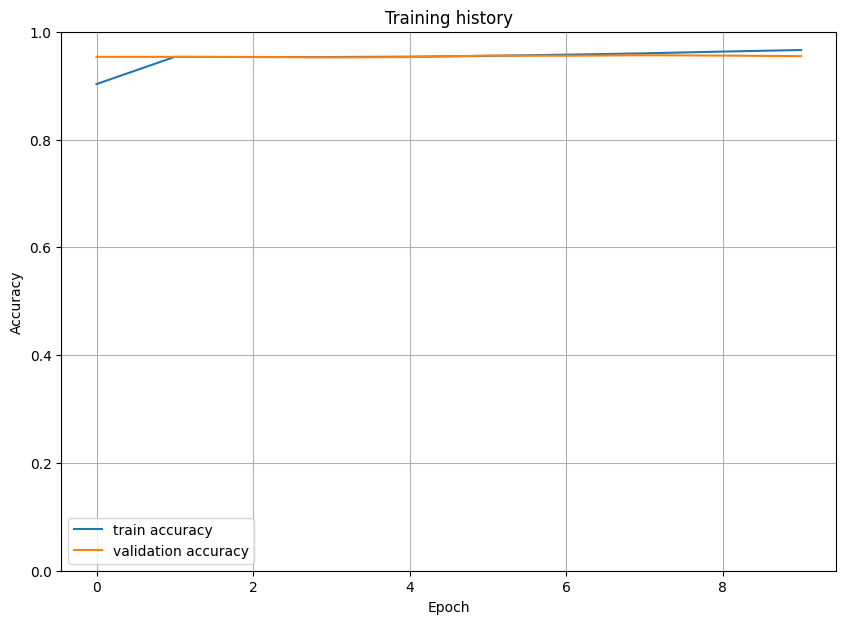

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [ ]:
# Loading pretrained model (best model)
model = BERTClass()
checkpoint = torch.load("/content/drive/MyDrive/bert_model/best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])  # Use ['model_state_dict'] to access the model weights
model = model.to(device)


<ipython-input-47-070d87b3ead0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/bert_model/best_model.pt")


In [ ]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.9575809256286785

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [ ]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [ ]:
# sanity check
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:1869 
predictions:torch.Size([1869, 32]) 
prediction_probs:torch.Size([1869, 32]) 
target_values:torch.Size([1869, 32])


In [ ]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [ ]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Predicting on raw text

In [ ]:
raw_text = "I saw a red apple so all the apples are red"

In [ ]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Title: I saw a red apple so all the apples are red
Label: hasty generalization
